*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/fall24/notebooks/module07_04_cnns.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Convolutional networks

### Preface:  enabling GPUs on google colab

Until now we ran our neural networks on a CPU.  If you are running this notebook on google colab, you are in luck - google colab will allow you to run your code on a GPU.  Enabling a GPU is very simple:  All you need to do is navigate to Edit→Notebook Settings and select GPU from the Hardware Accelerator drop-down.
This [colab notebook](https://colab.research.google.com/notebooks/gpu.ipynb) has instructions for verifying that you are using a GPU and see the resulting speedup.


In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
# torch imports 
import torch,torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
torch.manual_seed(42);

/Users/asa/miniconda3/envs/courses/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/asa/miniconda3/envs/courses/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/asa/miniconda3/envs/courses/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <85021449-F141-385B-8151-410662B4D328> /Users/asa/miniconda3/envs/courses/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# if you have a GPU we should enable it
# mps is the pytorch device that supports GPU computations on MacOS

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
#device = "cpu"

Using mps device


## The MNIST dataset

In [4]:
data = torchvision.datasets.MNIST('/Users/asa/datasets',
                                  train=True,
                                  transform = ToTensor(),
                                  download=True,
                                 )
test_data = torchvision.datasets.MNIST('/Users/asa/datasets',
                                  train=False,
                                  transform = ToTensor(),
                                  download=True,
                                 )


In [5]:
X_train_list = [data[i][0].flatten().numpy() for i in range(len(data))]
X_train = np.row_stack(X_train_list)
y_train = np.array([data[i][1] for i in range(len(data))])
X_test_list = [test_data[i][0].flatten().numpy() for i in range(len(test_data))]
X_test = np.row_stack(X_test_list)
y_test = np.array([test_data[i][1] for i in range(len(test_data))])

X_train.shape,X_test.shape

((60000, 784), (10000, 784))

## Convolutional Neural Networks

Previously, we had identified two main issues with fully connected networks on image tasks:

* **Very large numbers of parameters with increasing image sizes**.  Consider for example images of size 228x228x3, which is standard in this field.  Mapping this data to a hidden layer with 100 neurons will require 228\*228\*3\*100 parameters from the input to the hidden layer - about 15,000,000.  This network would also not be successful - we would need to significantly increase the width and depth, compounding the issue.  It is likely that billions of parameters would be necessary to achieve good accuracy.
* **Lack of translational invariance**.  If we take an image that represents the number seven, and shift the seven over a few pixels, we would expect it to still be classified as a seven.  However, fully connected networks are not able to represent this invariance.

Convolutional layers allow us to address both issues.

<img style="width:50%;" alt="A simplified schema of the human visual pathway by Miquel Perello Nieteo CC BY-SA 4.0" src="https://upload.wikimedia.org/wikipedia/commons/b/bf/Human_visual_pathway.svg">

Convolutional layers are (somewhat loosely) inspired by human vision systems, specifically the lateral geniculate nucleus (LGN) and the visual cortex.  In the above image, everything from the visual field to the LGN can be considered as the "input" to the network that the LGN and visual cortex form.  Since there are two eyes, this is somewhat analagous to an ensemble of two networks running on slightly different inputs.

Both the LGN and visual cortex are split into a number of "layers" which perform various processing tasks while passing information from the optic nerve through.  For example, the visual cortex is split into six parts - V1 through V6.  V1, the primary visual cortex, identifies edges and lines in what is being viewed while preserving their relative locations in the image. That information is passed to deeper layers in the visual cortex.  [Biological Inspirations of Convolutional Neural Network](https://medium.com/@gopalkalpande/biological-inspiration-of-convolutional-neural-network-cnn-9419668898ac) and [Visual system](https://en.wikipedia.org/wiki/Visual_system) go more into depth on what those biological systems do.

Let's walk through how we can identify edges in images mathematically.  We'll start by looking at two images where identifying vertical or horizontal edges could help with classification:

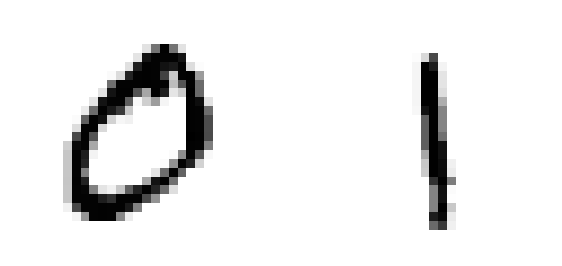

In [6]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.imshow(X_train[1].reshape(28,28), cmap='Greys')
ax.axis('off')

ax2.imshow(X_train[8].reshape(28,28), cmap='Greys')
ax2.axis('off');

We can identify the edges with a "filter" that we "convolve" over the image - we basically take a small matrix of numbers, and then for every pixel in the image we calculate the result of overlaying the matrix at that pixel.  In the below animation, the set of blue blocks are the input image, the darker blue region is where the filter is being applied, and the gray blocks are the output.

<img style="width:50%;" alt="Convolution example by Irhum Shafkat available at https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1" src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif">

The following [article](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) from which this image is used is a useful resource for learning about convolution, and goes into more detail than this notebook does about certain aspects of them.  The paper [A Guide to Convolution Arithmetic for Deep Learning by Vincent Dumoulin and Frencesco Visin](https://github.com/vdumoulin/conv_arithmetic) and its associated GitHub repository may also be a useful resource, although the paper is somewhat involved.

If we apply the filter
$$ \begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix} $$
to the digits zero and one using this convolution structure, we get:

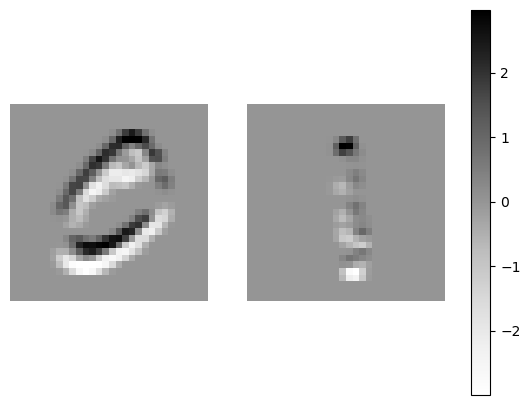

In [7]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

conv_result = scipy.signal.convolve2d(X_train[1].reshape(28, 28), 
                                      np.array([[1,2,1],[0,0,0],[-1,-2,-1]]))
ax.imshow(conv_result, cmap='Greys')
ax.axis('off')

conv_result = scipy.signal.convolve2d(X_train[8].reshape(28, 28), 
                                      np.array([[1,2,1],[0,0,0],[-1,-2,-1]]))
im = ax2.imshow(conv_result, cmap='Greys')
ax2.axis('off')
fig.colorbar(im, ax=[ax, ax2]);

Here edges are represented by values with high magnitude, negative or positive, which correspond to the white and black pixels.  If we look for vertical edges (with the transpose of the horizontal edge matrix), we get

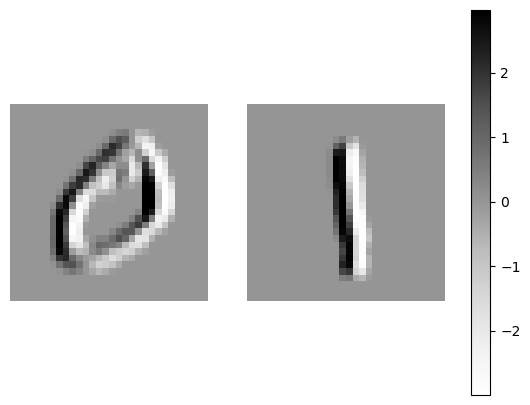

In [8]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

conv_result = scipy.signal.convolve2d(X_train[1].reshape(28, 28), 
                                      np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T)
ax.imshow(conv_result, cmap='Greys')
ax.axis('off')

conv_result = scipy.signal.convolve2d(X_train[8].reshape(28, 28), 
                                      np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T)
ax2.imshow(conv_result, cmap='Greys')
ax2.axis('off')
fig.colorbar(im, ax=[ax, ax2]);

This isn't the method one would use for calculating edges in practice, but it still gives an example of what convolution does and how it can find potentially meaningful features.

There are two other notes to make:
* One of these filters only has nine parameters, but interacts with the entire image.  Using multiple filters can give us a number of meaningful features while using relatively few parameters.
* This exploits the local structure of the image to create useful features.  Because the same filter is used everywhere, we don't need to worry about finding a fully constructed structure that will give us edge detection no matter where on the image we look - that happens for free.  Converting this to a "fully connected" layer in a neural network would require 784 nodes (really 900 - see next point).
* Behavior on boundaries is important to keep in mind to avoid size issues.  As shown in the animation of convolutions, applying the 3x3 filter to every location that it doesn't run off the edge of the image, it will shrink by one pixel on each side, resulting in a 26x26 image for MNIST.  However, if we look at the size of one of the images resulting from the convolution we calculated:

In [9]:
conv_result.shape

(30, 30)

it's not 28x28 or 26x26 - it's 30x30.  The signal subpackage from SciPy defaults to adding "padding" around the input image.  If a single "pixel" of padding is added for a 3x3 filter, we end up with an output that is the same size as the input, as shown in the figure below:

<img style="width:50%;" alt="Convolution padding example by Irhum Shafkat available at https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1" src="https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif">

There are a few methods for determining what value a padding "pixel" has - the three most common are looping around the edges, extending the adjacent pixel, and setting the value to zero.  Of those, zero padding is the most common.

SciPy defaults to *two* pixels of padding on each edge, which results in one pixel being added to each edge of the output.  Keras, however, defaults to having no padding.  The amount of padding necessary to maintain the input image size also changes based on the size of the filter - a 3x3 filter needs one pixel of padding, but a 5x5 filter would need two pixels of padding.

In addition to padding, convolutional layers also have a stride parameter.  This parameter controls how far the filter moves along the original image when generating the output:

<img style="width:50%;" alt="Strides by Vincent Dumoulin and Frencesco Visin https://github.com/vdumoulin/conv_arithmetic" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif">

The above stride is two, rather than the default one from earlier images, and effectively "halves" the size of the input image in each dimension.  This result in subsampling of the image, which helps to reduce the amount of data (and therefore the number of parameters) passed through the network.

Another form of subsampling is pooling, where the image is downsampled according to some algorithm.  One common method of doing this is max-pooling, where the maximum value in some region is passed as the value for the corresponding pixel in the output:

<img style="width:50%;" alt="Max Pooling by Aphex34 CC BY-SA 4.0 https://en.wikipedia.org/wiki/File:Max_pooling.png" src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png">

Max pooling can also give local translational invariance.  If we moved a seven in one of our images to the right slightly, we would still want it to be classified in the same way.  Traditional fully connected networks have no method for explicitly learning to do this (although convolutions can help during the training process), but max pooling gives that invariance for free in the "receptive fields" of later layers - the region of pixels in the original image that influence the value of a pixel in a later layer.

The "typical" convolutional neural network (CNN) structure is to have repeated convolutional and pooling layers, although a number of variations on this structure exist.

<img style="width:100%;" alt="Max Pooling by Aphex34 CC BY-SA 4.0 https://en.wikipedia.org/wiki/File:Typical_cnn.png" src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png">

The outputs of convolutional layers are often referred to as "features," as they describe abstract features of the original image.

With all of that background out of the way, we can now construct a CNN for MNIST:

In [10]:
class mnist_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Question
Given this network structure, with multiple convolutional layers before the same dense layer we saw previously, do you expect it to have (roughly)
1. Half the parameters than the fully connected network
2. The same number of parameters as the fully connected network
3. Double the number of parameters of the fully connected network
4. 10x more parameters than the fully connected network
5. 100x more parameters than the fully connected network

### Back to the network

Now that we have the network setup, we can train it.  Each epoch will take longer than the fully connected network due to the complexity of the calculations that must be done.

In [11]:
model = mnist_cnn().to(device)
print(model)

mnist_cnn(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    # set the model to training mode - important when you have 
    # batch normalization and dropout layers
    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 100 == 0:
            current = (batch_idx + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    return total_loss / num_batches

def validation(dataloader, model, loss_fn):
    # set the model to evaluation mode 
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage 
    # for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


In [13]:
learning_rate = 0.001
batch_size = 64
epochs = 5

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                               shuffle=True)

model = mnist_cnn().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
validation_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    loss, accuracy = validation(valid_dataloader, model, loss_fn)
    validation_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.311691  [   64/60000]
loss: 0.414207  [ 6464/60000]
loss: 0.126149  [12864/60000]
loss: 0.137312  [19264/60000]
loss: 0.141227  [25664/60000]
loss: 0.036712  [32064/60000]
loss: 0.079493  [38464/60000]
loss: 0.338051  [44864/60000]
loss: 0.024217  [51264/60000]
loss: 0.028230  [57664/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.036829 

Epoch 2
-------------------------------
loss: 0.156440  [   64/60000]
loss: 0.089111  [ 6464/60000]
loss: 0.060074  [12864/60000]
loss: 0.086465  [19264/60000]
loss: 0.010493  [25664/60000]
loss: 0.033477  [32064/60000]
loss: 0.101317  [38464/60000]
loss: 0.013357  [44864/60000]
loss: 0.021258  [51264/60000]
loss: 0.021761  [57664/60000]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.029364 

Epoch 3
-------------------------------
loss: 0.008368  [   64/60000]
loss: 0.010573  [ 6464/60000]
loss: 0.028066  [12864/60000]
loss: 0.003389  [19264/60000]
loss: 0.023370  [25664/60000]
loss: 0.012489  [32064/600

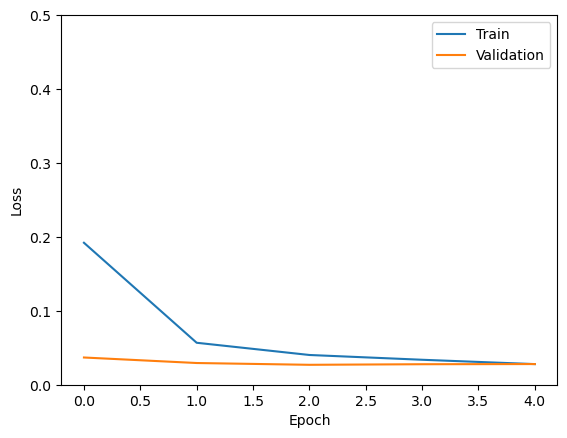

In [14]:
plt.plot(train_loss, label='Train')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();
plt.ylim([0, 0.5]);

This network converges to a good solution very quickly and ends with slightly better than 99% accuracy on the test set, an increase over the fully connected network's 97.5%.

This may not seem like a significant increase over the fully connected network, but there are two points that make it impressive:
1. This network requires half as many parameters
2. Raw percentages are useful, but don't tell the whole story.  Increasing from 50% to 75% accuracy is a raw increase of 25%, and halves the error rate from 50% to 25%.  Increasing from 98% to 99% is a raw increase of 1%, but it also halves the error rate from 2% to 1%.  In general, as the accuracy increases, increasing it further becomes more difficult and can be suprisingly beneficial.

**Todo**: look at a few of the images the network misclassifies.

There are genuine mistakes in this set of images, but there are also images that for various reasons, such as poor cropping or poor handwriting, are difficult to classify.  Something that is not uncommon is datasets having a certain amount of label noise.

### Comments

* MNIST is a relatively easy image classification task, and for more realistic benchmarks the difference between fully connected and convolutional networks is much more dramatic.
* In the last notebook we provided some intuition into what the networks are doing.  With the high input dimension and complexity of these networks, that kind of analysis is now significantly more difficult.  However, there are resources that provide visualizations of what certain parts of the network are doing - [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/) is one such resource that provides an interactive analysis of some features.  The host website ([distill.pub](https://distill.pub)) is also a good resource for learning about complex topics in neural networks.